# Colab 사용자를 위한 안내

해당 노트북은 **로컬** 환경에서 최적화 되어 있습니다. 로컬 환경에서 진행하시는 분들은 바로 학습을 진행하시면 됩니다.

Colab 을 사용하시는 분들은 처음에 아래 주석을 해제하시고 한번 만 실행시켜주세요!

* 주석을 해제하는 방법: 해당 영역을 선택하고, `Ctrl + /` 를 누르면 해당 영역의 주석에 해제됩니다.

In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Colab 을 사용하시는 분들은 아래 주석을 해제하시고 `folder` 변수 명에 프로젝트 디렉토리를 저장한 위치를 작성해주세요! 예를 들어, `03_rnn_tf` 의 위치가 "내 드라이브 > colab_notebook > tensorflow" 폴더 안에 있는 경우, "colab_notebook/tensorflow" 를 작성하시면 됩니다.

```python
folder = "colab_notebook/tensorflow"
```

In [2]:
import os
from pathlib import Path

# folder 변수에 구글드라이브에 프로젝트를 저장한 디렉토리를 입력하세요!
folder = "Colab Notebooks/tensorflow/"
project_dir = "03_rnn_tf"

base_path = Path("/content/gdrive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/gdrive/My Drive/Colab Notebooks/tensorflow/03_rnn_tf


TensorFlow 는 `1.14.0` 버전을 기준으로 합니다. Colab 사용시, 첫번째 코드를 실행해보시고 만약에 버전이 다르다면 두 번째 주석을 해제하고 실행해주세요.

In [3]:
import tensorflow as tf
print('tensorflow version: {}'.format(tf.__version__))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

tensorflow version: 1.14.0


In [0]:
# !pip install tensorflow-gpu==1.14.0

# Recurrent Neural Network: Neural Weather Forecaster

<img src="http://drive.google.com/uc?export=view&id=139sr_X8Hi8O8s43syKDxW7UCF33X_mjh" width="600px" height="800px" />

* 이미지 출처: 네이버

많은 사람이 아침에 집을 나서기 전에 오늘 기온이 어떤지 혹은 비가 오는지 알기 위해 일기예보를 확인합니다. 그런데 혹시 일기예보가 어떻게 이루어지는지 생각해 보신적이 있으신가요? 아직 오지도 않은 미래의 날씨를 어떻게 예측할 수 있을까요? 아마 여러분 대부분은 기상 예측과 관련된 전문적인 지식에 대해 잘 알지 못할 것입니다. 엄청난 계산능력을 갖춘 슈퍼컴퓨터가 복잡한 계산을 통해 예측을 한다는 정도는 들어보신 분들도 계실 수 있겠네요. 하지만 딥러닝을 활용할 수 있고, 지난 과거의 기후 데이터만 가지고 있으면 여러분의 PC에서도 훌륭한 일기예보 모델을 학습시킬 수 있습니다. 이번 프로젝트에서는 RNN을 직접 설계하여 24시간 후의 기온을 예측하는 문제를 해결할 것입니다.


이번 실습의 목표는 다음과 같습니다.
- RNN을 설계하여 지난 며칠 동안의 날씨 정보를 기반으로 24시간 이후의 기온을 예측한다.
- 다양한 속성의 시계열 정보를 활용하기 위해 적절한 전처리 과정을 적용한다. 
- 설계한 모델의 성능을 검증하기 위해 베이스라인 모델을 도입한다.

실습코드는 Python 3.6, TensorFlow 1.14.0 버전을 기준으로 작성되었습니다.

이번 과정을 통해 얻는 최종 결과물은 아래 그림과 같습니다.

<img src="http://drive.google.com/uc?export=view&id=1UD4n1qLY2o3ayAQq-LOOiHd76qiCVAYk" width="600px" height="400px" />
<center>&lt;기온, 강수량 등 다양한 정보로 미래의 기온 예측&gt;</center></caption>

### 이제부터 본격적으로 프로젝트를 시작하겠습니다.

**"[TODO] 코드 구현"** 부분의 **"## 코드 시작 ##"** 부터 **"## 코드 종료 ##"** 구간에 필요한 코드를 작성해주세요. **나머지 작성구간이 명시 되지 않은 구간은 임의로 수정하지 마세요!**

**본문 중간중간에 TensorFlow 함수들에 대해 [TensorFlow API 문서](https://www.tensorflow.org/api_docs/python/tf) 링크를 걸어두었습니다. API 문서를 직접 확인하는 일에 익숙해지면 나중에 여러분이 처음부터 모델을 직접 구현해야 할 때 정말 큰 도움이 됩니다.**

<h1>목차<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Colab-사용자를-위한-안내" data-toc-modified-id="Colab-사용자를-위한-안내-1">Colab 사용자를 위한 안내</a></span></li><li><span><a href="#Recurrent-Neural-Network:-Neural-Weather-Forecaster" data-toc-modified-id="Recurrent-Neural-Network:-Neural-Weather-Forecaster-2">Recurrent Neural Network: Neural Weather Forecaster</a></span><ul class="toc-item"><li><span><a href="#1.-Package-load" data-toc-modified-id="1.-Package-load-2.1">1. Package load</a></span></li><li><span><a href="#2.-하이퍼파라미터-세팅" data-toc-modified-id="2.-하이퍼파라미터-세팅-2.2">2. 하이퍼파라미터 세팅</a></span></li><li><span><a href="#3.-데이터-전처리-함수-정의" data-toc-modified-id="3.-데이터-전처리-함수-정의-2.3">3. 데이터 전처리 함수 정의</a></span></li><li><span><a href="#4.-데이터-샘플-시각화" data-toc-modified-id="4.-데이터-샘플-시각화-2.4">4. 데이터 샘플 시각화</a></span></li><li><span><a href="#5.-Dataset-만들기" data-toc-modified-id="5.-Dataset-만들기-2.5">5. Dataset 만들기</a></span></li><li><span><a href="#6.-베이스라인-성능-측정" data-toc-modified-id="6.-베이스라인-성능-측정-2.6">6. 베이스라인 성능 측정</a></span></li><li><span><a href="#7.-네트워크-설계" data-toc-modified-id="7.-네트워크-설계-2.7">7. 네트워크 설계</a></span></li><li><span><a href="#8.-Loss-function,-Optimizer-정의" data-toc-modified-id="8.-Loss-function,-Optimizer-정의-2.8">8. Loss function, Optimizer 정의</a></span></li><li><span><a href="#9.-train,-validation,-test-함수-정의" data-toc-modified-id="9.-train,-validation,-test-함수-정의-2.9">9. train, validation, test 함수 정의</a></span></li><li><span><a href="#10.-Training" data-toc-modified-id="10.-Training-2.10">10. Training</a></span></li><li><span><a href="#11.-저장된-모델-불러오기-및-test" data-toc-modified-id="11.-저장된-모델-불러오기-및-test-2.11">11. 저장된 모델 불러오기 및 test</a></span></li><li><span><a href="#12.-Summary" data-toc-modified-id="12.-Summary-2.12">12. Summary</a></span></li></ul></li><li><span><a href="#Self-Review" data-toc-modified-id="Self-Review-3">Self-Review</a></span></li></ul></div>

## 1. Package load

필요한 패키지들을 로드합니다.

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from tensorflow.keras import layers
import tensorflow as tf
import check_util.checker as checker
from IPython.display import clear_output
import os
import time
import glob
import csv

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tf.enable_eager_execution()
print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

tensorflow version: 1.14.0
GPU 사용 가능 여부: True


## 2. 하이퍼파라미터 세팅

학습에 필요한 하이퍼파리미터의 값을 초기화해줍니다.

미니배치의 크기(`batch_size`), 학습 할 epoch 수(`max_epochs`), 학습률(`learning_rate`) 등의 값들을 다음과 같이 정합니다.

In [0]:
batch_size = 128
max_epochs = 30
learning_rate = 3e-5
hidden_sizes = [100, 100]  # hidden_sizes must be a list

## 3. 데이터 전처리 함수 정의

우리는 이번 실습에서 지난 10년간의(2009년~2018년) 서울시 기후 데이터를 활용해 기온을 예측하는 모델을 학습시킬 것입니다. 데이터셋은 [기상자료개방포털](https://data.kma.go.kr/)에서 받은 자료입니다. 이번 실습에서 사용하는 데이터 이외에도 기상자료개방포털에서 기상과 관련된 다양한 자료들을 내려받으실 수 있습니다. 

`./data/climate_seoul` 경로의 디렉토리를 보시면, `test` / `train` / `val` 디렉토리에 csv파일이 각각 1개 / 8개/ 1개 담겨있음을 확인하실 수 있습니다. 각 csv파일은 1년간의 서울시 기후 데이터를 담고 있으며, 1시간 간격으로 기록된 정보입니다. (사실 아주 가끔씩 30분 간격으로 기록한 구간도 있기도 하지만, 이후 본문에서는 편의상 모두 1시간 간격으로 기록된 것으로 간주하겠습니다.) 매 시간마다 기록되는 정보는 기온, 강수량, 풍속 등을 포함한 총 25가지 속성으로 이루어져 있습니다. 이 중에서 우리는 기온, 강수량, 풍속, 습도, 증기압을 포함한 총 9가지의 속성만을 사용하여 기온 예측 모델을 학습시켜 보겠습니다.

그렇다면 왜 하필 이 9가지의 속성을 선택한 것일까요? 이렇게 9가지의 속성을 선택한 배경에는 어떠한 전문적인 지식도 고려되지 않은 것입니다. 25가지의 속성을 모두 사용해볼 수도 있겠죠. 어떤 속성들을 활용할지는 설계자의 몫입니다. 그런데 여러분이 기상과 관련된 전문적인 지식을 갖고 있지 않는 이상 이중에서 어떤 속성이 기온 예측에 가장 중요한지, 또는 어떤 속성이 가장 불필요한 속성인지 알지 못할 것입니다. 하지만 고맙게도 딥러닝은 이러한 속성 선택 문제에 덜 예민한 학습 방식입니다. 더 정확하게 말하면, 다소 불필요한 정보가 입력으로 주어진다고 해서 극단적으로 학습이 이루어지지 않는 일은 일어나지 않을 가능성이 큽니다. 학습과정에서 인공신경망이 필요한 특징(feature)을 알아서 추출하기 때문입니다. 그러니까 우리는 어떤 속성을 활용할지를 너무 심각하게 고민하지 않아도 되는 것입니다. 다만 이번 실습에서는 매번 빠짐없이 잘 기록된 속성들을 위주로 9가지를 선택한 것 뿐입니다.

아래에 정의한 전처리 `preprocess` 함수는 csv파일들을 읽어 9가지 속성 정보만을 NumPy 배열에 저장해 반환하는 역할을 합니다. 이 함수는 이후에 `train_data`, `val_data`, `test_data`를 구현할 때 활용될 것입니다.

In [0]:
def preprocess(all_files):
    data_0 = []  # 기온
    data_1 = []  # 강수량
    data_2 = []  # 풍속
    data_3 = []  # 습도
    data_4 = []  # 증기압
    data_5 = []  # 이슬점 온도
    data_6 = []  # 현지 기압
    data_7 = []  # 해면 기압
    data_8 = []  # 지면 온도
    for f in all_files:
        with open(f, encoding='euc-kr') as c:
            csv_reader = csv.reader(c, delimiter=',')
            header = True
            for col in csv_reader:
                if header:
                    header = False
                    continue
                data_0.append(
                    float(col[2])) if col[2] != '' else data_0.append(0.0)
                data_1.append(
                    float(col[3])) if col[3] != '' else data_1.append(0.0)
                data_2.append(
                    float(col[4])) if col[4] != '' else data_2.append(0.0)
                data_3.append(
                    float(col[6])) if col[6] != '' else data_3.append(0.0)
                data_4.append(
                    float(col[7])) if col[7] != '' else data_4.append(0.0)
                data_5.append(
                    float(col[8])) if col[8] != '' else data_5.append(0.0)
                data_6.append(
                    float(col[9])) if col[9] != '' else data_6.append(0.0)
                data_7.append(
                    float(col[10])) if col[10] != '' else data_7.append(0.0)
                data_8.append(
                    float(col[22])) if col[22] != '' else data_8.append(0.0)

    data = np.zeros((len(data_0), 9))
    for i, d in enumerate(data):
        data[i, 0] = data_0[i]
        data[i, 1] = data_1[i]
        data[i, 2] = data_2[i]
        data[i, 3] = data_3[i]
        data[i, 4] = data_4[i]
        data[i, 5] = data_5[i]
        data[i, 6] = data_6[i]
        data[i, 7] = data_7[i]
        data[i, 8] = data_8[i]

    return data.astype(np.float32)

**preprocess**를 해주고 나면, 데이터가 다음 그림과 같이 매 시간마다 총 9가지의 속성만 저장됩니다.

<img src="http://drive.google.com/uc?export=view&id=1iA_SHcfJ9XnZ2w_S66GS_XpvRH7WNXGf" width="600px" height="400px" />

In [0]:
data_dir = './data/climate_seoul'

train_data = preprocess(sorted(glob.glob(os.path.join(data_dir, 'train', '*'))))
val_data = preprocess(sorted(glob.glob(os.path.join(data_dir, 'val', '*'))))
test_data = preprocess(sorted(glob.glob(os.path.join(data_dir, 'test', '*'))))

In [9]:
print("shape of train data: {}".format(train_data.shape))
print("shape of val data: {}".format(val_data.shape))
print("shape of test data: {}".format(test_data.shape))

shape of train data: (70133, 9)
shape of val data: (8760, 9)
shape of test data: (8760, 9)


## 4. 데이터 샘플 시각화

`train_data`의 첫번째 `column` 즉 온도 데이터를 그래프 형태로 시각화합니다.

$\Delta t = 240$: 240시간, 즉 10일 동안의 온도 그래프를 그려봅니다. 그림을 보면 10개의 주기적으로 나타나는 뽀죡한 고 점들을 볼 수 있는데 이 점들이 하루의 낮 최고 기온을 의미하는 것으로 보입니다. 

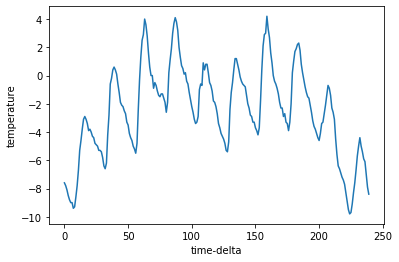

In [10]:
start = 0
dt = 240
plt.plot(train_data[start:start+dt, 0])
plt.ylabel("temperature")
plt.xlabel("time-delta")
plt.show()

## 5. Dataset 만들기

이제 우리가 사용할 데이터셋에 대해 정의할 차례입니다. 이를 위해  `make_dataset` 함수를 만들 것이며 여기서 사용되는 각 인수의 의미는 다음과 같습니다.

- `data`: **<3. 데이터 전처리 함수 정의>** 에서 정의한 전처리 `preprocess` 함수로 얻은 `train_data`, `val_data`, `test_data` 가 됩니다. `data`의 shape은 (데이터의 총 길이, 9)가 됩니다.
- `seq_length`: 우리가 이후에 설계할 RNN의 입력으로 줄 데이터 시퀀스의 길이, 즉 총 타임스텝의 길이를 뜻합니다. 다시 말하면, 현재로부터 24시간 뒤의 기온을 예측하기 위해 얼마만큼의 과거 정보를 참고할지 결정하는 것입니다. 기본값을 480로 해두었는데, 이는 480개의 과거 데이터를 살펴보겠다는 것이고, 데이터 1개는 1시간마다 기록되기 때문에 결과적으로 지난 20일간의 데이터를 기반으로 24시간 후의 기온을 예측하겠다는 의미입니다.
- `target_delay`: 우리가 예측할 시점이 입력 시퀀스의 마지막 타임스텝으로 얼만큼 이후인지 결정하는 것입니다. 24로 기본값을 해두었고, 이는 24시간 이후의 기온이 우리가 예측할 대상임을 의미하는 것입니다. 예를 들어 1월 1일 00:00 부터 1월 21 일 23:00 까지 480 개의 데이터를 이용한다면 예측 데이터는 1월 21일 23:00 로부터 24 시간 후인 1월 22일 23:00 시점의 기온입니다.
- `strides`: 학습할 데이터의 양을 조절하기 위해 만든 옵션 입니다. $\Delta t = 10$, `strides=1`이라고 할 때 $\mathbf{x}^{(1)} = [x_{1}, x_{2}, \cdots, x_{10}]$, $\mathbf{x}^{(2)} = [x_{2}, x_{3}, \cdots, x_{11}]$, $\mathbf{x}^{(3)} = [x_{3}, x_{4}, \cdots, x_{12}]$ 이런식으로 데이터를 사용합니다. 우리가 사용하는 데이터의 time step이 많기 때문에 `strides=1`이면 굉장히 많은 수의 training data를 가질 수 있습니다. gpu가 없거나 빠른 테스트를 위한다면 `strides`를 조절하여 데이터 양을 조절하면 좋을 것 같습니다. 예를들어 `strides=3`이면 $\mathbf{x}^{(1)} = [x_{1}, x_{2}, \cdots, x_{10}]$, $\mathbf{x}^{(2)} = [x_{4}, x_{5}, \cdots, x_{13}]$, $\mathbf{x}^{(3)} = [x_{7}, x_{8}, \cdots, x_{16}]$ 이와 같이 sampling을 하여 데이터를 사용합니다.
<img src="http://drive.google.com/uc?export=view&id=1DJ6lybrsRD8D8TtHBvbo-DU7zi-U4JMm"  width="800px" height="300px" />
- `mode`: `train`, `val`, `test`를 뜻합니다.
- `train_mean`, `train_std`: 입력으로 사용하는 데이터의 각 속성은 저마다 값의 범위가 다릅니다. 예를 들어 기온은 보통 -15에서 35사이의 값을 갖지만, 강수량과 풍속은 음수 값이 존재하지 않고, 기압의 경우에는 1000 내외의 값이 일반적입니다. 이러한 경우 각각의 속성들을 저마다의 평균과 표준편차를 통해 값을 정규화(normalize)해주는 것이 바람직합니다. 정규화 시 `train`, `val`, `test` 각각의 데이터셋에 대해서 진행하는 것이 아니라 `train` 데이터 셋에서 구한 평균인 `train_mean`과 표준편차인 `train_std`를 이용하여 `val`, `test` 데이터 셋을 정규화해야 합니다.

### <font color='red'>[TODO] 코드 구현</font>

이제 다음을 읽고 코드를 완성해보세요.
1. `mode`에 맞게 정규화(normalize) 코드를 작성해보세요.
    - 1-1 : `train` 모드일 때: `train` 디렉토리에 있는 데이터 셋의 `mean`, `std`를 구해야 합니다. 함수를 사용할 경우 `axis`를 주의해 주세요.
    - 1-2 : `val` 또는 `test` 모드일 때: `train_mean`, `train_std`를 이용합니다.
    - 1-3 : normalize 코드를 작성해보세요. (수식은 다음과 같습니다.)
        - $ (X - \mathbb{E}(X)) \, / \, \sqrt{ \mathrm{Var} (X) } $.
        - $\mathbb{E}(X)$ 는 데이터의 평균, $\sqrt{ \mathrm{Var} (X) }$ 는 데이터의 표준편차입니다.
2. `for`문으로 전체 타임스텝 (`range(len(data) - seq_length - target_delay)`)을 돌면서 인덱스(변수명 `index`)가 `stride`로 나누어 떨어질 때만 훈련 데이터 셋으로 저장을 합니다.
    - 2-1 : `stride=3` 이면 `index`가 0, 3, 6, 9, ... 일 때만 `sequence`와 `target`에 데이터를 집어넣는 것입니다. 즉 해당 인덱스는 각 배치 데이터의 첫번째 인덱스가 됩니다. 따라서 `data` 변수에 해당하는 데이터를 `index`부터 `seq_length`(480시간)만큼 잘라내어 `sequence`에 추가합니다. 이는 곧 모델에게 전달되는 입력 데이터가 됩니다.
    - 2-2 : `data`의 `index`부터 `seq_length`만큼의 떨어진 위치에서 다시 `target_delay`(즉 24시간) 만큼 떨어진 위치의 기온(0번째 컬럼)을 target에 추가합니다.
3. 최종 Numpy로 변경되었을때 `sequence`의 shape은 (N, `seq_length`, 9), `target`의 shape은 (N,)이 되어야 합니다. N은 전체 데이터 갯수 입니다.

**make_dataset 함수 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [0]:
def make_dataset(data, seq_length=480, target_delay=24, strides=5,
                 mode='train', train_mean=None, train_std=None):
    '''
        각 인수에 대한 설명은 위의 'Dataset만들기' 설명을 참고하세요.
    '''
    assert mode in ['train', 'val', 'test']
    if mode is not 'train':
        if train_mean is None or train_std is None:
            print('Current mode is {}'.format(mode))
            print('This mode needs mean and std of train data')
            assert False

    # 정규화
    ## 코드 시작 ##
    if mode is 'train':
        mean = np.mean(data, axis=0)    # 위의 설명 1-1 을 참고하여 None을 채우세요.
        std = np.std(data, axis=0)     # 위의 설명 1-1 을 참고하여 None을 채우세요.
    else: 
        mean = train_mean    # 위의 설명 1-2 를 참고하여 None을 채우세요.
        std = train_std     # 위의 설명 1-2 를 참고하여 None을 채우세요.
    data = (data-mean)/std        # 위의 설명 1-3 을 참고하여 None을 채우세요.
    ## 코드 종료 ##
    
    # 입력, 타겟 데이터 생성
    sequence = []
    target = []
    for index in range(len(data) - seq_length - target_delay):
        if index % strides == 0:
            ## 코드 시작 ##
            sequence.append(data[index:index+seq_length])    # 위의 설명 2-1 을 참고하여 None을 채우세요.
            target.append(data[index+seq_length:index+seq_length+target_delay][-1][0])      # 위의 설명 2-2 를 참고하여 None을 채우세요.
            ## 코드 종료 ##

    if mode is 'train':
        return np.array(sequence), np.array(target), mean, std
    else:
        return np.array(sequence), np.array(target)

이제 학습용, 검증용, 테스트용 dataset을 만들어 봅니다.

In [0]:
seq_length = 480
target_delay = 24
strides = 5
train_sequences, train_labels, train_mean, train_std = make_dataset(
    train_data, seq_length, target_delay, strides, mode='train')
val_sequences, val_labels = make_dataset(
    val_data, seq_length, target_delay, strides, mode='val', train_mean=train_mean, train_std=train_std)
test_sequences, test_labels = make_dataset(
    test_data, seq_length, target_delay, strides, mode='test', train_mean=train_mean, train_std=train_std)

In [13]:
print(train_sequences.shape)
print(train_labels.shape)
print(train_mean.shape)
print(train_std.shape)

(13926, 480, 9)
(13926,)
(9,)
(9,)


#### Input pipeline 만들기

`tf.data.Dataset`을 이용하여 `train`, `val`, `test`의 input pipeline 구축합니다.
* `tf.data.Dataset.from_tensor_slices`: `numpy`타입(또는 리스트 형태의 데이터)의 데이터를 `tf.data.Dataset`포맷의 데이터로 변환시켜줍니다.
* `tf.data.Dataset.shuffle`: 데이터셋을 shuffle 시켜줍니다.
* `tf.data.Dataset.batch`: 데이터셋의 batch_size를 결정합니다.

In [0]:
# shuffle의 인자로 buffer_size가 필요한데 이는 전체 데이터셋 갯수로 하는게 좋습니다.
N = BUFFER_SIZE = len(train_sequences)  # number of samples in train_dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_sequences, train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(batch_size)

`val`, `test`데이터 셋은 shuffle할 필요가 없습니다. 
* `train`시 shuffle하는 목적은 mini-batch gradient descent를 하기 위해 mini-batch 데이터를 random 하게 뽑는 것입니다. 
* `val`, `test` 데이터 셋의 목적은 모든 데이터셋을 다 보고 성능을 평가하기 위함입니다. 그렇기 때문에 `val`, `test`데이터 셋은 shuffle할 필요가 없습니다.

In [0]:
# val_dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_sequences, val_labels))
val_dataset = val_dataset.batch(batch_size)

# test_dataset
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_sequences, test_labels))
test_dataset = test_dataset.batch(batch_size)

아래의 코드를 실행해 코드를 성공적으로 완성했는지 확인해보세요. 

별다른 문제가 없다면 이어서 진행하면 됩니다.

In [16]:
checker.customized_dataset_check(train_sequences, train_labels, train_dataset, train_mean, train_std, seq_length, target_delay, strides)

tf.data.Dataset을 잘 구현하셨습니다! 이어서 진행하셔도 좋습니다.


## 6. 베이스라인 성능 측정

이후에 우리가 학습시킨 모델의 성능의 좋고 나쁨을 판단할 기준(베이스라인)이 필요합니다. 적당한 수준의 기준 성능을 정해놓고 테스트 결과에서 우리의 모델이 그것보다 더 좋은 성능을 보이면 만족할만한 모델을 학습시킨 것으로 간주하면 되고, 반대로 그보다 성능이 좋지 않다면 모델을 더 개선시키는 방식으로 네트워크 구조를 변경해 나아가면 됩니다.

과거의 기후 정보를 활용하는 우리의 딥러닝 모델이 과연 의미있는 성능이라는 걸 보이기 위해서는 어떠한 예측 방식이 기준이 될 수 있을까요? 아마 기온 예측 전문가가 아닌 대부분의 여러분이 지금으로부터 24시간 후의 기온을 예측하라는 질문을 받았다고 생각해 봅시다. 아마 가장 무난하면서도 안정적으로 예측하는 방식은 지금의 기온과 같다고 답하는 것일 겁니다. 이러한 예측 방식은 과거의 기후 정보를 복잡하게 고려할 필요도 없이 간단하지만, 많은 경우에 실제로 꽤나 정확한 예측을 할 수 있는 방식입니다. 내일 낮 12시의 기온은 특이한 경우가 아니라면, 오늘 낮 12시의 기온과 거의 비슷할 것입니다.

### <font color='red'>[TODO] 코드 구현</font>

아래의 `eval_baseline` 함수는 베이스라인 모델의 평균 loss를 측정하는 함수입니다. 다음을 읽고 코드를 완성해보세요.

1. 우리의 베이스라인은 현재 기온을 24시간 후의 기온으로 예측하는 방식입니다. 현재 기후 정보는 `test_dataset`에서 받은 `sequences`의 가장 마지막 타임스텝에 담겨있습니다. 입력으로 주는 `sequences`는 기온 뿐만 아니라 총 9가지 속성이 포함된 것임에 유의하세요. 기온은 9가지 속성중 가장 첫번째에 위치하고 있음을 염두에 두고 `sequences`로 부터 현재 "기온"을 가져와 `predictions` 변수에 저장하세요.
2. `loss_fn` 은 차후에 넣을 손실함수(loss function)입니다. `loss_fn` 함수의 첫번째 인자로 추정치인 `predictions`, 두번째 인자로 실제 24시간 이후의 기온인 `targets`을 이용하여 측정된 loss를 `loss` 변수에 저장하세요. (힌트: `loss_fn`는 함수 타입을 넣을 것임으로 다음과 같이 사용할 수 있습니다. <br> `함수(1번 인자, 2번인자, ...)`)

**eval_baseline 함수 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [0]:
def eval_baseline(dataset, loss_fn):
    mean_loss = tf.keras.metrics.Mean("mean_loss")
    for sequences, targets in dataset:
        ## 코드 시작 ##
        predictions = sequences[:, -1, 0]    # 위의 설명 1. 을 참고하여 None을 채우세요.
        loss = loss_fn(predictions, targets)          # 위의 설명 2. 를 참고하여 None을 채우세요.
        ## 코드 종료 ##
        mean_loss(loss)
        
    print('Baseline Average Loss: {:.4f}'.format(mean_loss.result()))
    return mean_loss.result()

베이스라인의 성능을 측정합니다. 다음과 같은 결과가 출력된다면 성공적으로 구현한 것입니다.

> Baseline Average Loss: 0.0993

In [18]:
loss_object = tf.keras.losses.MeanSquaredError()
baseline_loss = eval_baseline(test_dataset, loss_object)

Baseline Average Loss: 0.0993


평균 loss만 봐서는 베이스라인이 어느 정도로 예측을 잘하는지 감이 잘 오지 않습니다. 베이스라인 모델의 예측 기온과 실제 기온을 몇가지 살펴보면 다음과 같습니다.

In [19]:
for i in range(10):
    data_idx = np.random.randint(len(test_sequences))
    pred = test_sequences[data_idx, -1, 0]
    # 예측 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    pred = pred * train_std[0] + train_mean[0]
    # 실제 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    target = test_labels[data_idx] * train_std[0] + train_mean[0]
    print('예측 기온: {:.1f} / 실제 기온: {:.1f} / 차이: {:.1f}'.format(
        pred, target, pred - target))

예측 기온: 15.0 / 실제 기온: 14.8 / 차이: 0.2
예측 기온: 4.9 / 실제 기온: -1.6 / 차이: 6.5
예측 기온: 21.0 / 실제 기온: 22.2 / 차이: -1.2
예측 기온: 12.7 / 실제 기온: 9.8 / 차이: 2.9
예측 기온: 16.1 / 실제 기온: 22.2 / 차이: -6.1
예측 기온: 31.5 / 실제 기온: 32.1 / 차이: -0.6
예측 기온: 0.5 / 실제 기온: -6.4 / 차이: 6.9
예측 기온: 3.8 / 실제 기온: 8.3 / 차이: -4.5
예측 기온: 19.8 / 실제 기온: 22.8 / 차이: -3.0
예측 기온: -2.1 / 실제 기온: -5.7 / 차이: 3.6


## 7. 네트워크 설계

우리는 LSTM 구조를 통해 기온 예측을 모델을 학습시킬 것입니다. 설계할 네트워크의 대략적인 개요는 아래 그림과 같습니다.

<img src="http://drive.google.com/uc?export=view&id=1AjxdDivdX23DSdubayKhAAcXmWfRBSvb"  width="800px" height="400px" />

LSTM의 매 타임스텝의 입력은 매 시간마다 기록된 9가지 속성값이 들어가게 됩니다. 그리고 마지막 타입스텝의 출력을 마무리로 Dense 레이어에 넣어 최종 예측 기온값을 출력하는 구조입니다.  

### <font color='red'>[TODO] 코드 구현</font>

우리가 구현할 클래스는 `SimpleLSTM`입니다. 다음을 읽고 코드를 완성해보세요.

1. [`tf.keras.layers.CuDNNLSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/CuDNNLSTM) 또는 [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)을 사용하여 모델을 만들어보세요.
    - 만약 여러분이 GPU를 가지고 계시다면 `CuDNNLSTM` 아니라면 `LSTM`을 사용하시면 됩니다.
    - `tf.test.is_gpu_available()`를 사용하시면 GPU 사용이 가능한지 알 수 있습니다.
    - 첫번째 코드를 실행하면 GPU 보유에 따라서 해당하는 LSTM 층 함수를 `rnn_layer` 변수에 할당하게 됩니다.
2. 생성자의 파라미터 `hidden_sizes`는 우리가 설계할 LSTM 레이어의 hidden state의 크기입니다. 이 크기를 얼마를 할지는 역시 설계자의 몫입니다. `hidden_sizes`는 리스트로 값을 받습니다. 예를 들어 `hidden_sizes = [4, 8, 16]` 이면 첫 번째 layer의 `units=4`, 두 번째 layer의 `units=8`, 세 번째 layer의 `units=16` 입니다.
    -  **<2. 하이퍼파라미터 세팅>** 에서 우리는 첫 번째 layer의 `units=100`, 두 번째 layer의 `units=100`으로 하였습니다.
    - `self.hidden_size` 에 `hidden_sizes` 를 대입하세요.
3. `self.num_layers` 는 출력을 포함한 RNN 층의 개수 입니다. 즉, `hidden_sizes` 리스트의 길이가 됩니다.
4. `self.rnn` 에 `rnn_layer` 를 넣어서 RNN 층을 구성하세요! 먼저 첫번째부터 마지막 이전 층까지 for 문을 통해 층을 쌓고(stack), 마지막층은 따로 쌓을 것입니다.
    - rnn_layer의 첫번째 인자는 히든 뉴런의 수입니다. 또한 여러 층으로 쌓고 싶다면 `rnn_layer`의 인자   `return_sequences=True` 를 꼭 해주어야 합니다.
    - 맨 마지막 층의 `rnn_layer`의 최종 state를 가지고 `dense` 연산을 할 것 입니다. 따라서 맨 마지막은 `outputs` 값으로 모든 sequence 정보가 필요 없습니다. `return_sequences=False` (default) 를 하시면 됩니다.
5. `self.rnn`에서 나온 최종 state를 `dense` 레이어에 연결합니다. 이때 [`layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)를 이용하면 됩니다. 우리는 "기온"이라는 하나의 실수를 예측할 것을 기억하세요!
6. 마지막으로 `call` 함수에서  `self.rnn`과 `self.dense`를 연결하여 마무리하면 됩니다.

**모델 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [20]:
# GPU 사용 가능한지 체크, 해당 블록은 실행만 하면 됩니다.
if tf.test.is_gpu_available():
    print("Using 'tf.keras.layers.CuDNNLSTM'")
    rnn_layer = tf.keras.layers.CuDNNLSTM
else:
    print("Using `tf.keras.layers.LSTM`")
    rnn_layer = tf.keras.layers.LSTM

Using 'tf.keras.layers.CuDNNLSTM'


In [0]:
class SimpleLSTM(tf.keras.Model):
    def __init__(self, hidden_sizes):
        super(SimpleLSTM, self).__init__()
        assert isinstance(hidden_sizes, list)
        ## 코드 시작 ##
        self.hidden_sizes = hidden_sizes    # 위의 설명 2. 를 참고하여 None을 채우세요.
        self.num_layers = len(hidden_sizes)      # 위의 설명 3. 을 참고하여 None을 채우세요.
        ## 코드 종료 ##
        
        # RNN 층 쌓기
        ## 코드 시작 ##
        self.rnn = []
        for i in range(self.num_layers-1):
            self.rnn.append(tf.keras.layers.CuDNNLSTM(self.hidden_sizes[i], return_sequences=True))   # 위의 설명 4. 를 참고하여 None을 채우세요.
        self.rnn.append(tf.keras.layers.CuDNNLSTM(self.hidden_sizes[self.num_layers-1], return_sequences=False))       # 위의 설명 4. 를 참고하여 None을 채우세요.
        ## 코드 종료 ##
        
        # Dense 층 만들기
        ## 코드 시작 ##
        self.dense = layers.Dense(1)           # 위의 설명 5. 를 참고하여 None을 채우세요.
        ## 코드 종료 ##

    def call(self, x):
        # 입력 데이터인 x 가 RNN 층 > Dense 층 통과
        # 코드 시작
        for i in range(self.num_layers):
            x = self.rnn[i](x)                # RNN 층 통과: 위의 설명 6. 을 참고하여 None을 채우세요.
        x = self.dense(x)                    # Dense 층 통과: 위의 설명 6. 을 참고하여 None을 채우세요.
        ## 코드 종료 ##

        return x

아래의 코드 블록은 SimpleLSTM을 이용해서 모델을 생성해보고 데이터를 집어 넣어서 잘 동작하는지 확인해 보는 코드 입니다.

In [0]:
model = SimpleLSTM(hidden_sizes)
for step, (sequences, targets) in enumerate(train_dataset.take(1)):
    predictions = model(sequences)

`summary()` API로 모델이 잘 구성됐는지 확인해 봅니다.

In [23]:
model.summary()

Model: "simple_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       multiple                  44400     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     multiple                  80800     
_________________________________________________________________
dense (Dense)                multiple                  101       
Total params: 125,301
Trainable params: 125,301
Non-trainable params: 0
_________________________________________________________________


아래의 코드를 실행해 코드를 성공적으로 완성했는지 확인해보세요. 

별다른 문제가 없다면 이어서 진행하면 됩니다.

In [24]:
checker.model_check(model)

네트워를 잘 구현하셨습니다! 이어서 진행하셔도 좋습니다.


## 8. Loss function, Optimizer 정의

생성한 모델을 학습 시키기 위해서 손실함수를 정의해야 합니다. 뉴럴네트워크는 경사하강(gradient descent)방법을 이용하여 손실함수의 값을 줄이는 방향으로 파라미터를 갱신(update) 하게 됩니다. 또한 효과적인 경사하강 방법을 적용하기 위해 옵티마이져를 함께 사용할 겁니다.

### <font color='red'>[TODO] 코드 구현</font>

다음을 읽고 코드를 완성해보세요. 

1. 연속된 값을 예측하는 Regression 문제에서는 손실함수로 Mean Squared Error를 사용합니다. [`tf.keras.losses.MeanSquaredError()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError)를 만들고 `loss_object` 변수에 저장합니다.
2. 옵티마이저로 Adam optimizer를 사용하겠습니다. [`tf.train.AdamOptimizer()`](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)를 `optimizer` 변수에 저장합니다. **<2. 하이퍼파라미터 세팅>** 에서 정의한 `learning_rate` 로 학습률을 지정해보세요!

**이제 손실함수와 옵티마이저 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [0]:
## 코드 시작 ##
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.train.AdamOptimizer(learning_rate)
## 코드 종료 ##

# record loss for every epoch
mean_loss = tf.keras.metrics.Mean("loss")

아래의 코드를 실행해 코드를 성공적으로 완성했는지 확인해보세요. 

별다른 문제가 없다면 이어서 진행하면 됩니다.

In [26]:
checker.loss_function_check(loss_object)
checker.optimizer_check(optimizer)

MSE loss function을 잘 정의하셨습니다! 이어서 진행하셔도 좋습니다.
Adam optimizer를 잘 정의하셨습니다! 이어서 진행하셔도 좋습니다.


## 9. train, validation, test 함수 정의

이번에는 훈련, 검증, 테스트를 진행하는 함수를 정의하겠습니다.

### <font color='red'>[TODO] 코드 구현: 훈련 함수</font>

먼저 훈련 함수입니다. 다음을 읽고 코드를 완성해 보세요.

1 epoch 내에서 훈련을 진행하는 `train_step` 함수는 `model`, `sequences`와 `targets`를 인자로 받습니다.

1. `predictions`: `model`에게 데이터를 입력하여 결과를 `predictions`로 저장합니다.
2. **<8. Loss function, Optimizer 정의>** 에서 정의한 `loss_object`를 이용하여 `targets`과 `predictions`의 손실값을 `loss_value`에 저장합니다.
    * `loss_object`의 인자로 사용될 `predictions`의 차원 수를 [`tf.squeeze`](https://www.tensorflow.org/api_docs/python/tf/squeeze)를 이용하여 맞춰줘야 합니다. squeeze함수는 1로 표현되는 차원을 제거 합니다.
3. `tape`로 정의된 [`tf.GradientTape()`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) 객체의 `gradient` 메서드를 이용하여 `loss_value`를 `model.trainable_variables`로 미분하고, 이 값을 `gradients` 변수에 저장합니다.
4. [`optimizer.apply_gradients()`](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer#methods)를 이용하여 파라미터를 업데이트 합니다. 함수 인자로 `gradients`와 `model.trainable_variables`를 zip으로 묶어서 전달하면 됩니다.
  
### Define training one step function

**train_step 함수 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [0]:
def train_step(model, sequences, targets):
    ## 코드 시작 ##
    with tf.GradientTape() as tape:
        predictions = model(sequences)    # 위의 설명 1. 을 참고하여 None을 채우세요.
        loss_value = loss_object(y_true=targets, y_pred=tf.squeeze(predictions))     # 위의 설명 2. 를 참고하여 None을 채우세요.

    gradients = tape.gradient(loss_value, model.trainable_variables)                # 위의 설명 3. 을 참고하여 None을 채우세요.
    optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # 위의 설명 4. 를 참고하여 None을 채우세요.
    ## 코드 종료 ##

    return loss_value

### Define validation and test functions

### <font color='red'>[TODO] 코드 구현: 검증 함수</font>

검증 함수입니다. 다음을 읽고 코드를 완성해 보세요.

검증 과정에서는 파라미터 업데이트를 하지 않기 때문에 gradients를 계산할 필요가 없습니다. 일정한 에폭마다 검증 데이터인 `val_dataset` 을 이용하여 검증을 수행합니다. 모델 검증을 수행했을 때, 만약 검증 과정의 평균 loss가 현재까지 가장 낮다면 가장 잘 훈련된 모델로 가정하고 그때까지 학습한 모델을 저장합니다. 저장은 추후에 구현할 `save_model` 함수가 수행합니다.

`validation` 함수는 `model`, `val_dataset`와 `epoch`을 인자로 받습니다.
1. `predictions`: `model`에게 데이터를 입력한 결과를 `predictions`에 저장합니다.
2. **<8. Loss function, Optimizer 정의>** 에서 정의한 `loss_object`를 이용하여 loss를 구합니다. (`targets`와 `predictions` 필요)
    * `loss_object`의 인자로 사용될 `predictions`의 차원 수를 [tf.squeeze](https://www.tensorflow.org/api_docs/python/tf/squeeze)를 이용하여 맞춰주는 것도 잊지 마세요.
    
**validation 함수 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [0]:
def validation(model, val_dataset, epoch):
    print('Start validation #{}'.format(epoch))
    val_mean_loss = tf.keras.metrics.Mean("val_loss")

    for sequences, targets in val_dataset:
        ## 코드 시작 ##
        predictions = model(sequences)    # 위의 설명 1. 을 참고하여 None을 채우세요.
        val_loss_value = loss_object(y_true=targets, y_pred=tf.squeeze(predictions))
        ## 코드 종료 ##
        
        val_mean_loss(val_loss_value)

    print('Validation #{} epoch  Average Loss: {:.4g}\n'.format(
        epoch, val_mean_loss.result()))

    return val_mean_loss.result()

### <font color='red'>[TODO] 코드 구현: 테스트 함수</font>

테스트 함수입니다. 다음을 읽고 코드를 완성해 보세요.

1. `predictions`: `model`에게 데이터를 입력한 결과를 `predictions`에 저장합니다.
2. **<8. Loss function, Optimizer 정의>** 에서 정의한 `loss_object`를 이용하여 loss를 구합니다. (`targets`와 `predictions` 필요)
    * `loss_object`의 인자로 사용될 `predictions`의 차원 수를 [tf.squeeze](https://www.tensorflow.org/api_docs/python/tf/squeeze)를 이용하여 맞춰주는 것도 잊지마세요.
    
`test`함수를 이용하여 베이스라인과 모델의 성능비교를 진행합니다.

**test 함수 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [0]:
def test(model, test_dataset, baseline_loss):
    print('Start test..')
    test_mean_loss = tf.keras.metrics.Mean("test_loss")

    for sequences, targets in test_dataset:
        ## 코드 시작 ##
        predictions = model(sequences)    # 위의 설명 1. 을 참고하여 None을 채우세요.
        test_loss_value = loss_object(y_true=targets, y_pred=tf.squeeze(predictions))
        ## 코드 종료 ##
        test_mean_loss(test_loss_value)
        
    print('BaseLine Loss {:.4g}'.format(baseline_loss.numpy()))
    print('Test Average Loss: {:.4g}'.format(test_mean_loss.result()))

    if test_mean_loss.result().numpy() < baseline_loss:
        print('베이스라인 성능을 뛰어 넘었습니다!')
    else:
        print('아쉽지만 베이스라인 성능을 넘지 못했습니다.')

    return test_mean_loss.result()

### 모델 저장 함수 정의

다음 코드는 `train_dir` 폴더에 모델을 저장하는 함수 `save_model` 입니다.

In [0]:
def save_model(model, epoch, train_dir):
    model_name = 'my_model_' + str(epoch)
    model.save_weights(os.path.join(train_dir, model_name))

## 10. Training

`train_step` 함수를 통해 학습을 진행합니다. LSTM과 같은 recurrent layer는 타임스텝을 따라 계산이 순차적으로 진행되기 때문에 상대적으로 학습 시간이 많이 소요됩니다. 따라서 시간 여유가 없는 분들은 모델 학습이 적당히 진행된다는 정도만 확인하고 다음 단계로 넘어가셔도 됩니다.

만약 한 에폭 이상이 지나도록 loss가 전혀 감소하는 기미가 보이지 않는다면 이전의 구현에 문제가 있을 가능성이 높으니 코드를 다시 검토해주시기 바랍니다. 이러한 경우에는 구현한 `train_step` 함수를 다시 한 번 확인하시기 바랍니다. 

또한, 모델 저장 코드를 제대로 구현했다면 첫 에폭 학습후에 `train_dir` 경로에 `my_model_{}.data` 파일이 저장되어 있어야 합니다. 만약에 파일이 존재하지 않는다면 모델 저장 코드를 다시 확인하시기 바랍니다.

`val_epoch`은 검증을 몇 에폭마다 진행할지 정하는 변수입니다. `print_steps` 는 훈련 과정의 출력 정도를 관장하는 변수입니다. 작으면 작을 수록 자주 출력하게 됩니다. 원하는 만큼 조절해보시길 바랍니다.

In [0]:
train_dir = os.path.join('./train/exp1')
print_steps = 30
val_epoch = 1

### <font color='red'>[TODO] 코드 구현: main 함수</font>

이전에 정의한 `train_step`, `validation` 함수를 사용하여 전체 훈련을 진행하는 `main` 함수 코드를 작성합니다. 전체 프로세스는 다음과 같습니다.

* `max_epochs` 동안 훈련하는데 아래 과정을 반복합니다.
    * `train_dataset` 에서 미니배치 데이터와 라벨을 가져옵니다.
    * `train_step` 함수를 통해 훈련합니다.
    * `validation` 함수를 통해 모델을 검증합니다. 분류 성능이 이전 단계보다 좋다면 저장하게 됩니다. 

**main 함수 코드를 작성해보세요! "<font color='45A07A'>## 코드 시작 ##</font>"과 "<font color='45A07A'>## 코드 종료 ##</font>" 사이의 <font color='075D37'>None</font> 부분을 채우시면 됩니다.**

In [0]:
def main(model, train_dataset, val_dataset, val_epoch, print_steps, save_dir):
    print('Start training..')
    num_batches_per_epoch = len(list(train_dataset))
    global_step = 0
    best_loss = 999999.

    for epoch in range(max_epochs):
        for step, (sequences, targets) in enumerate(train_dataset):

            start_time = time.time()
            # train_step 함수 사용하여 loss 구하기
            ## 코드 시작 ##
            loss_value = train_step(model, sequences, targets)
            ## 코드 종료 ##
            mean_loss(loss_value)
            global_step += 1

            if global_step % print_steps == 0:
                duration = time.time() - start_time
                examples_per_sec = batch_size / float(duration)
                clear_output(wait=True)
                print("Epochs: [{}/{}] step: [{}/{}] loss: {:.4g}  ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                    epoch+1, max_epochs, step+1, num_batches_per_epoch,
                    mean_loss.result(), examples_per_sec, duration))

            mean_loss.reset_states()

        if (epoch + 1) % val_epoch == 0:
            # validation 함수 사용하여 검증하기
            # 여기서 epoch는 0부터 시작하기 때문에 + 1 을 해주시길 바랍니다.
            ## 코드 시작 ##
            val_mean_loss = validation(model, val_dataset, epoch)
            ## 코드종료 ##
            if val_mean_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save in {}\n'.format(save_dir))
                best_loss = val_mean_loss
                save_model(model, epoch+1, save_dir)

    print('training done..')

다음 코드를 통해 모델 훈련을 시작하세요! CPU만을 사용한 학습일 경우 굉장히 오랜 시간이 걸립니다.

In [33]:
main(model, train_dataset, val_dataset, val_epoch, print_steps, save_dir=train_dir)

Epochs: [30/30] step: [109/109] loss: 0.07774  (1954.77 examples/sec; 0.065 sec/batch)
Start validation #29
Validation #29 epoch  Average Loss: 0.06757

Best performance at epoch: 30
Save in ./train/exp1

training done..


## 11. 저장된 모델 불러오기 및 test

학습한 모델의 성능을 테스트합니다. 저장한 모델 파일을 `model.load_weights()`를 통하여 불러올 수 있습니다. 모델의 저장 및 불러오기를 좀 더 자세히 알고 싶으면 [Save and restore](https://www.tensorflow.org/guide/keras#save_and_restore) 문서를 참고하세요. 위에서 학습을 끝까지 진행하지 않았다면, 첫번째 주석 처리된 부분을 주석 해제하여, 제공해드린 미리 학습시킨 모델을 불러올 수 있습니다. 

In [34]:
# train_dir = './train/pretrained' # 모델 학습을 끝까지 진행하지 않은 경우에 사용

# 아래의 모델 불러오기를 정확히 구현했는지 확인하기 위해 새로 모델을 선언하여 학습 이전 상태로 초기화
model = SimpleLSTM(hidden_sizes)  
# inputs을 넣어 모델 생성
for sequences, targets in train_dataset.take(1):
    outputs = model(sequences)
# 모델 파라미터 불러오기
model.load_weights(tf.train.latest_checkpoint(train_dir))

마지막으로 모델의 성능을 테스트합니다. 베이스라인 성능을 뛰어 넘었다는 문구가 나오면 성공적으로 진행한 것입니다. 

In [35]:
test_acc_value = test(model, test_dataset, baseline_loss)

Start test..
BaseLine Loss 0.09927
Test Average Loss: 0.08346
베이스라인 성능을 뛰어 넘었습니다!


학습된 모델의 예측 기온과 실제 기온을 몇가지 살펴보면 다음과 같습니다.

In [36]:
for i in range(10):
    data_idx = np.random.randint(len(test_sequences))
    pred = model(test_sequences[data_idx:data_idx+1, :, :]).numpy()[0, 0]
    # 예측 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    pred = pred * train_std[0] + train_mean[0]
    # 실제 기온을 normalization 이전 상태(섭씨 단위)로 되돌리는 작업
    target = test_labels[data_idx] * train_std[0] + train_mean[0]
    print('예측 기온: {:.1f} / 실제 기온: {:.1f} / 차이: {:.1f}'.format(
        pred, target, pred - target))

예측 기온: 26.7 / 실제 기온: 29.4 / 차이: -2.7
예측 기온: 23.4 / 실제 기온: 24.1 / 차이: -0.7
예측 기온: 26.1 / 실제 기온: 25.2 / 차이: 0.9
예측 기온: 23.9 / 실제 기온: 27.2 / 차이: -3.3
예측 기온: 28.9 / 실제 기온: 30.6 / 차이: -1.7
예측 기온: -0.2 / 실제 기온: 0.6 / 차이: -0.8
예측 기온: 7.8 / 실제 기온: 6.9 / 차이: 0.9
예측 기온: -4.5 / 실제 기온: -10.4 / 차이: 5.9
예측 기온: 23.8 / 실제 기온: 22.2 / 차이: 1.6
예측 기온: 19.9 / 실제 기온: 18.5 / 차이: 1.4


어떠신가요? 잘 맞는것 같나요? 모델 구조의 은닉층 크기(`hidden_size`) 등 다양한 하이퍼파라미터를 조절해서 더 좋은 성능을 내는 모델을 만들어보세요!

## 12. Summary

이로써 마지막 RNN 프로젝트를 완료했습니다. 고생하셨습니다! 

우리는 이번 실습을 통해 다음과 같은 내용을 학습했습니다.
- 날씨와 같은 시계열 정보를 다룰 수 있다.
- RNN을 설계하고 시간 순서상 미래의 정보를 예측하는 모델을 학습시킬 수 있다.
- 상식적인 수준의 베이스라인을 도입하여 학습한 모델의 성능을 검증할 수 있다.

# Self-Review

학습 환경에 맞춰 알맞는 제출방법을 실행하세요!

### 로컬 환경 실행자

1. 모든 실습 완료 후, Jupyter Notebook 을 `Ctrl+S` 혹은 `File > Save and checkpoint`로 저장합니다.
2. 제일 하단의 코드를 실행합니다. 주의할 점은 Jupyter Notebook 의 파일이름을 수정하시면 안됩니다! 만약에 노트북 이름을 수정했다면 "tensorflow-rnn-project" 로 바꿔주시길 바랍니다. 모든 평가 기준을 통과하면, 함수 실행 후 프로젝트 "submit" 디렉토리와 압축된 "submit.zip"이 생깁니다. "cnn_submission.tsv" 파일을 열고 모두 Pass 했는지 확인해보세요!
    * "rnn_submission.tsv" : 평가 기준표에 근거해 각 세부항목의 통과여부(Pass/Fail) 파일
    * "rnn_submission.html" : 여러분이 작성한 Jupyter Notebook 을 html 형식으로 전환한 파일
3. 코드 실행결과 안내에 따라서 `submit.zip` 파일을 확인하시고 제출해주시길 바랍니다.

### Colab 환경 실행자

1. 모든 실습 완료 후, Jupyter Notebook 을 `Ctrl+S` 로 저장합니다.
2. 제일 하단의 코드를 실행합니다. 코드 실행결과 안내에 따라서 재작성하거나 다음스텝으로 넘어갑니다. 모든 평가 기준을 통과하면, 함수 실행 후 프로젝트 "submit" 디렉토리와 압축된 "rnn_submission.tsv"만 생깁니다. "rnn_submission.tsv" 파일을 열고 모두 Pass 했는지 확인해보세요!
    * "rnn_submission.tsv" : 평가 기준표에 근거해 각 세부항목의 통과여부(Pass/Fail) 파일
3. 프로젝트를 저장한 드라이브의 `submit` 폴더에서 `rnn_submission.tsv` 파일을 다운 받습니다.
4. Colab Notebook 에서 `파일 > .ipynb 다운로드` 를 통해서 노트북을 다운로드 받습니다.
5. 로컬에서 Jupyter Notebook 프로그램을 실행시킵니다. 
6. 4번 스텝에서 다운받은 노트북을 열고 `File > Download as > HTML(.html)` 로 재 다운로드 합니다.
7. 3번 스텝에서 받은 파일과 6번 스텝에서 받은 파일을 하나의 폴더에 넣고, `submit.zip` 이라는 이름으로 압축하고 제출해주시길 바랍니다.

In [37]:
import check_util.submit as submit
submit.process_submit()

[ Self-Check ] 시스템: Linux
[ Self-Check ] Submit 파일 생성완료! 위치: 'submit'
[ Self-Check ] submit.zip 생성 완료!
[ Self-Check ] 모든 평가기준을 통과했습니다. 압축파일을 제출해주세요!
